<a href="https://colab.research.google.com/github/juehao0816/Churn-Prediction/blob/master/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Churn Prediction

Juehao Hu

## Contents

# Part 0: Upload dataset from local

In [0]:
from google.colab import files
uploaded = files.upload()

Saving churn.all.csv to churn.all (2).csv


In [0]:
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['churn.all.csv']))
df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


# Part 1 : Data Exploration

## Part 1.1 : Dataset description

In [0]:
print("Number of rows:" + str(df.shape[0]))
print("Number of columns:" + str(df.shape[1]))

Number of rows:5000
Number of columns:21


## Part 1.2 : Data cleaning

The column "voice_mail_plan", "intl_plan" and "churned" have extra white space in every observation. We need to remove these whitespace.

In [0]:
# check categorical feature
df['voice_mail_plan'][0]

' yes'

In [0]:
# remove the heading and trailing whitespaces
# strip() in-built function of Python is used to remove all the leading and trailing spaces from a string.
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x: x.strip())
df['intl_plan'] = df['intl_plan'].map(lambda x: x.strip())
df['churned'] = df['churned'].map(lambda x: x.strip()) 

In [0]:
# check categorical feature after manipulation
df['voice_mail_plan'][0]

'yes'

## Part 1.3 : Understand the features

In [0]:
# check the missing value
df.isnull().sum()

state                            0
account_length                   0
area_code                        0
phone_number                     0
intl_plan                        0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churned                          0
dtype: int64

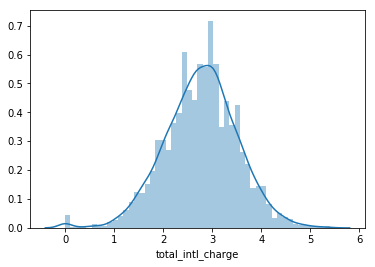

In [0]:
# check the feature distribution 
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df['total_intl_charge'])

In [0]:
# correlation between all the features
corr = df[["account_length", "number_vmail_messages", "total_day_minutes", 
           "total_day_calls", "total_day_charge", "total_eve_minutes", 
           "total_eve_calls", "total_eve_charge", "total_night_minutes", 
           "total_night_calls", "total_night_charge", "total_intl_minutes", 
           "total_intl_calls", "total_intl_charge"]].corr()

# check the actual values of correlations
corr

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge
account_length,1.000000,-0.014575,-0.001017,0.028240,-0.001019,-0.009591,0.009143,-0.009587,0.000668,-0.007825,0.000656,0.001291,0.014277,0.001292
number_vmail_messages,-0.014575,1.000000,0.005381,0.000883,0.005377,0.019490,-0.003954,0.019496,0.005541,0.002676,0.005535,0.002463,0.000124,0.002505
total_day_minutes,-0.001017,0.005381,1.000000,0.001935,1.000000,-0.010750,0.008128,-0.010760,0.011799,0.004236,0.011783,-0.019486,-0.001303,-0.019415
total_day_calls,0.028240,0.000883,0.001935,1.000000,0.001936,-0.000699,0.003754,-0.000695,0.002804,-0.008308,0.002802,0.013097,0.010893,0.013161
total_day_charge,-0.001019,0.005377,1.000000,0.001936,1.000000,-0.010747,0.008129,-0.010757,0.011801,0.004235,0.011785,-0.019490,-0.001307,-0.019419
total_eve_minutes,-0.009591,0.019490,-0.010750,-0.000699,-0.010747,1.000000,0.002763,1.000000,-0.016639,0.013420,-0.016642,0.000137,0.008388,0.000159
total_eve_calls,0.009143,-0.003954,0.008128,0.003754,0.008129,0.002763,1.000000,0.002778,0.001781,-0.013682,0.001799,-0.007458,0.005574,-0.007507
total_eve_charge,-0.009587,0.019496,-0.010760,-0.000695,-0.010757,1.000000,0.002778,1.000000,-0.016649,0.013422,-0.016652,0.000132,0.008393,0.000155
total_night_minutes,0.000668,0.005541,0.011799,0.002804,0.011801,-0.016639,0.001781,-0.016649,1.000000,0.026972,0.999999,-0.006721,-0.017214,-0.006655
total_night_calls,-0.007825,0.002676,0.004236,-0.008308,0.004235,0.013420,-0.013682,0.013422,0.026972,1.000000,0.026949,0.000391,-0.000156,0.000368


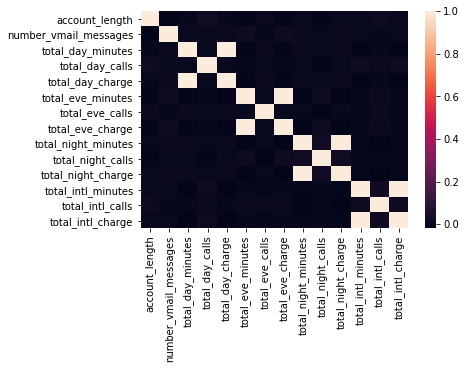

In [0]:
# Show the heatmap of correlations
sns.heatmap(corr)

From the correlation matrix we can see, the correlation between "total_charge" and "total_minutes" is 1. Hence, we can delete one of the them in each pair.


In [0]:
# Delete the high correlation variable: shot_distance, game_event_id,game_id
churn = df.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'], axis = 1)


# Part 2 : Feature Preprocessing

In [0]:
# Drop some useless columns
churn = churn.drop(['state', 'area_code', 'phone_number'], axis = 1)

In [0]:
# Label Encoding for String
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
churn.intl_plan = labelencoder.fit_transform(churn.intl_plan)
churn.voice_mail_plan = labelencoder.fit_transform(churn.voice_mail_plan)
churn.churned = labelencoder.fit_transform(churn.churned)

In [0]:
# Get X and y
X = churn.iloc[:, :-1].values
y = churn.iloc[:, -1].values

In [0]:
# Check the proportion of y = 1
print(y.sum()/y.shape)

[0.1414]


# Part 3 : Model Training -- Random Forest

## Part 3.1 : Split dataset

In [0]:
# Split data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

print('Training data has %d observation with %d features' % X_train.shape)
print('Test data has %d observation with %d features' % X_test.shape)

Training data has 4000 observation with 13 features
Test data has 1000 observation with 13 features


In [0]:
# Scale the data, using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3.2 : Model Training and Selection


In [0]:
# build models
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_RF.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Prediction of test data
classifier_RF.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# Accuracy of test data
classifier_RF.score(X_test, y_test)

0.942

In [0]:
# Use 5-fold Cross Validation to get the accuracy of different models
cv_score = model_selection.cross_val_score(classifier_RF, X_train, y_train, cv = 5)
print('Model accuracy of Random Forest is :', cv_score.mean())

Model accuracy of Random Forest is : 0.9384980484344506


## Part 3.3 Find Optimal Hyperparameters

### 1. Import function and build helper function for print out results

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import time

In [0]:
# Helper function for printing out results
def print_search_metrics(OH):
  print ("Best score: %0.5f" %OH.best_score_)
  print ("Best parameters set:")
  best_parameters = OH.best_params_
  for param_name in sorted(parameters.keys()):
    print ("\t%s : % r" % (param_name, best_parameters[param_name]))

### 2. Use Grid Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparameter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' :[40, 60, 80]
}

# Use time function to measure time elapsed
start = time.time()

Grid_RF = GridSearchCV(RandomForestClassifier(), parameters, cv = 5)
Grid_RF.fit(X_train, y_train)

end = time.time()

print (end - start)

5.022441625595093


In [0]:
# print best parameters
print_search_metrics(Grid_RF)

Best score: 0.94800
Best parameters set:
	n_estimators : 80


In [0]:
# best random forest in Grid Search
best_RF_grid = Grid_RF.best_estimator_

### 3. Use Random Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' :[40, 60, 80]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_RF = RandomizedSearchCV(RandomForestClassifier(), parameters, cv=5)
Random_RF.fit(X_train, y_train)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


4.8683061599731445


In [0]:
# print best parameters
print_search_metrics(Random_RF)

Best score: 0.94975
Best parameters set:
	n_estimators : 60


In [0]:
# best random forest in Random Search
best_RF_random = Random_RF.best_estimator_

### 4. Use Bayesian Optimization to Find Optimal Hyperparameters


In [0]:
def rf_cv(n_estimators):
  val = cross_val_score(
  RandomForestClassifier(n_estimators = int(n_estimators),
                        random_state = 2),
  X_train, y_train, scoring = 'accuracy', cv = 5).mean()
  return val

In [0]:
rf_bo = BayesianOptimization(
        rf_cv,{'n_estimators':(40, 80)
              }
)

In [0]:
# Use time function to measure time elapsed
start = time.time()

num_iter = 10
init_points = 5
rf_bo.maximize(init_points = init_points, n_iter = num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | n_esti... |
-------------------------------------
|  1        |  0.9483   |  73.39    |
|  2        |  0.9473   |  42.74    |
|  3        |  0.9483   |  73.74    |
|  4        |  0.948    |  62.27    |
|  5        |  0.949    |  55.46    |
|  6        |  0.9488   |  80.0     |
|  7        |  0.9473   |  40.0     |
|  8        |  0.9488   |  80.0     |
|  9        |  0.9488   |  79.99    |
|  10       |  0.9488   |  80.0     |
|  11       |  0.9488   |  80.0     |
|  12       |  0.9488   |  79.99    |
|  13       |  0.9488   |  79.98    |
|  14       |  0.9488   |  80.0     |
|  15       |  0.9488   |  80.0     |
63.309412717819214


In [0]:
rf_bo.max

{'params': {'n_estimators': 55.46001237383238}, 'target': 0.9490059035248493}

# Part 4 Model Training -- LGBM

## Part 4.1 Model Training and Selection

In [0]:
# build models
from lightgbm import LGBMClassifier
classifier_lgbm = LGBMClassifier()

In [0]:
# Train the model
classifier_lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# Prediction of test data
classifier_lgbm.predict(X_test)

In [0]:
# Accuracy of test data
classifier_lgbm.score(X_test, y_test)

0.963

In [0]:
# Use 5-fold Cross Validation to get the accuracy of different models
cv_score = model_selection.cross_val_score(classifier_lgbm, X_train, y_train, cv = 5)
print('Model accuracy of LGBM is :', cv_score.mean())

Model accuracy of LGBM is : 0.9559999453124146


## Part 4.2 Find Optimal Hyperparameters

### 1. Use Grid Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for LigntGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [20, 30, 50],
    'max_depth': [10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_LGBM = GridSearchCV(LGBMClassifier(),parameters, cv=5)
Grid_LGBM.fit(X_train, y_train)


end = time.time()
print(end - start)

226.95504450798035


In [0]:
# best number of tress
print_search_metrics(Grid_LGBM)

Best score: 0.96025
Best parameters set:
	learning_rate : 0.1
	max_depth : 30
	n_estimators : 100
	num_leaves : 50


In [0]:
# best random forest in Random Search
best_LGBM_Grid = Grid_LGBM.best_estimator_

### 2. Use Random Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for LightGBM
# Choose the number of trees
parameters = {
    'n_estimators' : [60, 80, 100, 200, 300],
    'learning_rate' : [0.03, 0.05, 0.08, 0.1, 0.2],
    'num_leaves' : [20, 30, 50],
    'max_depth': [10, 20, 30]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_LGBM = RandomizedSearchCV(LGBMClassifier(),parameters, cv=5)
Random_LGBM.fit(X_train, y_train)

end = time.time()
print(end - start)

9.542979717254639


In [0]:
# best number of tress
print_search_metrics(Random_LGBM)

Best score: 0.95900
Best parameters set:
	learning_rate : 0.05
	max_depth : 10
	n_estimators : 60
	num_leaves : 50


In [0]:
# best random forest in Random Search
best_LGBM_random = Random_LGBM.best_estimator_

### 3. Use Bayesian Optimization to Find Optimal Hyperparameters


In [0]:
def LGBM_cv(n_estimators, learning_rate, num_leaves, max_depth):
  val = cross_val_score(
      LGBMClassifier(n_estimators = int(n_estimators),
                     learning_rate = learning_rate,
                     num_leaves = int(num_leaves),
                     max_depth = int(max_depth),
                     random_state = 2
                    ),
      X_train, y_train, scoring= 'accuracy', cv=5
  ).mean()
  return val

In [0]:
LGBM_bo = BayesianOptimization(
    LGBM_cv,
    {'n_estimators': (60, 300),
     'learning_rate' : (0.01, 0.2),
     'num_leaves': (5, 50),
     'max_depth': (2, 30)}
)

In [0]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
LGBM_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.9553   |  0.01984  |  20.15    |  249.1    |  39.81    |
|  2        |  0.9543   |  0.18     |  29.92    |  104.0    |  37.07    |
|  3        |  0.9505   |  0.1062   |  3.805    |  179.4    |  19.57    |
|  4        |  0.9545   |  0.05421  |  10.79    |  92.14    |  45.04    |
|  5        |  0.9543   |  0.03651  |  24.66    |  292.4    |  22.56    |
|  6        |  0.9555   |  0.1025   |  29.69    |  295.3    |  49.84    |
|  7        |  0.9545   |  0.08646  |  29.86    |  295.1    |  49.8     |
|  8        |  0.9545   |  0.13     |  29.51    |  62.08    |  49.65    |
|  9        |  0.9543   |  0.1676   |  29.89    |  297.6    |  49.9     |
|  10       |  0.9555   |  0.1546   |  29.54    |  60.61    |  49.94    |
|  11       |  0.9533   |  0.03824  |  29.93    |  65.56    |  49.78    |
|  12       |  0.9473   |  0.154    | 

In [0]:
LGBM_bo.max

{'params': {'learning_rate': 0.15461347128101882,
  'max_depth': 29.53618153255665,
  'n_estimators': 60.606261929265585,
  'num_leaves': 49.943508821233856},
 'target': 0.9555059074311053}

# Part 5 Model Training -- Catboost

## Part 5.1 Model Training and Selection

In [0]:
# Build model
!pip install catboost

In [0]:
from catboost import CatBoostClassifier
classifier_cat = CatBoostClassifier(iterations = 100, task_type = 'GPU')

In [0]:
# Train the model
classifier_cat.fit(X_train, y_train)

In [0]:
# Prediction of test data
classifier_cat.predict(X_test)

In [0]:
# Accuracy of test data
classifier_cat.score(X_test, y_test)

0.956

In [0]:
# Use 5-fold Cross Validation to get the accuracy of different models
cv_score = model_selection.cross_val_score(classifier_cat, X_train, y_train, cv = 5)
print('Model accuracy of CatBoost is :', cv_score.mean())

## Part 5.2 Find Opitimal Hyperparameters

### 1. Use Grid Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for CatBoost
# Choose the number of trees
parameters = {
    'iterations' : [100, 200, 300],
    'learning_rate' : [0.08, 0.2],
    'depth': [2, 4, 6]
}

# Use time function to measure time elapsed
import time
start = time.time()

Grid_cat = GridSearchCV(CatBoostClassifier(task_type = 'GPU'),parameters, cv=5)
Grid_cat.fit(X_train, y_train)


end = time.time()
print(end - start)

0:	learn: 0.6475708	total: 4.35ms	remaining: 431ms
1:	learn: 0.6067099	total: 8.68ms	remaining: 425ms
2:	learn: 0.5716574	total: 12.2ms	remaining: 394ms
3:	learn: 0.5439836	total: 15.7ms	remaining: 377ms
4:	learn: 0.5176386	total: 18.9ms	remaining: 359ms
5:	learn: 0.4943321	total: 22.2ms	remaining: 348ms
6:	learn: 0.4733644	total: 25.4ms	remaining: 337ms
7:	learn: 0.4549568	total: 28.5ms	remaining: 328ms
8:	learn: 0.4387879	total: 31.8ms	remaining: 322ms
9:	learn: 0.4237841	total: 35.1ms	remaining: 316ms
10:	learn: 0.4125572	total: 38.3ms	remaining: 310ms
11:	learn: 0.4013437	total: 41.6ms	remaining: 305ms
12:	learn: 0.3909225	total: 44.8ms	remaining: 300ms
13:	learn: 0.3822336	total: 48ms	remaining: 295ms
14:	learn: 0.3730829	total: 51.1ms	remaining: 290ms
15:	learn: 0.3644848	total: 54.3ms	remaining: 285ms
16:	learn: 0.3571071	total: 57.5ms	remaining: 281ms
17:	learn: 0.3515692	total: 60.6ms	remaining: 276ms
18:	learn: 0.3455467	total: 63.9ms	remaining: 273ms
19:	learn: 0.3393981	tot

In [0]:
# best number of tress
print_search_metrics(Grid_cat)

Best score: 0.95875
Best parameters set:
	depth : 4
	iterations : 200
	learning_rate : 0.2


In [0]:
# best random forest in Random Search
best_cat_Grid = Grid_cat.best_estimator_

### 2. Use Random Search to Find Optimal Hyperparameters

In [0]:
# Possible hyperparamter options for CatBoost
# Choose the number of trees
parameters = {
    'iterations' : [100, 200, 300],
    'learning_rate' : [0.08, 0.2],
    'depth': [2, 4, 6]
}

# Use time function to measure time elapsed
import time
start = time.time()

Random_cat = RandomizedSearchCV(CatBoostClassifier(task_type = 'CPU'),parameters, cv=5)
Random_cat.fit(X_train, y_train)


end = time.time()
print(end - start)

0:	learn: 0.5367027	total: 6.14ms	remaining: 1.22s
1:	learn: 0.4332420	total: 11.8ms	remaining: 1.17s
2:	learn: 0.3703960	total: 17.6ms	remaining: 1.15s
3:	learn: 0.3239005	total: 23.3ms	remaining: 1.14s
4:	learn: 0.2878130	total: 28.9ms	remaining: 1.13s
5:	learn: 0.2671553	total: 35.4ms	remaining: 1.15s
6:	learn: 0.2558131	total: 41.3ms	remaining: 1.14s
7:	learn: 0.2422131	total: 46.9ms	remaining: 1.13s
8:	learn: 0.2327869	total: 52.5ms	remaining: 1.11s
9:	learn: 0.2238272	total: 58.4ms	remaining: 1.11s
10:	learn: 0.2172279	total: 64ms	remaining: 1.1s
11:	learn: 0.2085523	total: 69.8ms	remaining: 1.09s
12:	learn: 0.2040833	total: 75.4ms	remaining: 1.08s
13:	learn: 0.1967444	total: 81ms	remaining: 1.08s
14:	learn: 0.1932629	total: 86.5ms	remaining: 1.07s
15:	learn: 0.1857915	total: 91.9ms	remaining: 1.06s
16:	learn: 0.1796114	total: 97.5ms	remaining: 1.05s
17:	learn: 0.1748579	total: 104ms	remaining: 1.05s
18:	learn: 0.1711652	total: 109ms	remaining: 1.04s
19:	learn: 0.1699877	total: 1

In [0]:
# best number of tress
print_search_metrics(Random_cat)

Best score: 0.95800
Best parameters set:
	depth : 6
	iterations : 300
	learning_rate : 0.08


### 3. Use Bayesian Optimization to Find Optimal Hyperparameters


In [0]:
def cat_cv(iterations, learning_rate, depth):
  val = cross_val_score(
      CatBoostClassifier(iterations = int(iterations),
                         learning_rate = learning_rate,
                         depth = int(depth),
                         random_state = 2,
                         task_type = 'GPU'
                        ),
      X_train, y_train, scoring= 'accuracy', cv=5
  ).mean()
  return val

In [0]:
cat_bo = BayesianOptimization(
    cat_cv,
    {'iterations' : (60, 300),
     'learning_rate' : (0.03, 0.2),
     'depth': (2, 10)
    }
)

In [0]:
# Use time function to measure time elapsed
import time
start = time.time()

num_iter = 10
init_points = 5
cat_bo.maximize(init_points=init_points,n_iter=num_iter)

end = time.time()
print(end - start)

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
0:	learn: 0.6665446	total: 5.35ms	remaining: 1.05s
1:	learn: 0.6414105	total: 9.59ms	remaining: 940ms
2:	learn: 0.6190761	total: 13.9ms	remaining: 904ms
3:	learn: 0.5980895	total: 18.9ms	remaining: 917ms
4:	learn: 0.5777859	total: 23.4ms	remaining: 904ms
5:	learn: 0.5593856	total: 27.6ms	remaining: 883ms
6:	learn: 0.5417002	total: 32.2ms	remaining: 878ms
7:	learn: 0.5245784	total: 36.5ms	remaining: 868ms
8:	learn: 0.5093394	total: 40.7ms	remaining: 856ms
9:	learn: 0.4952621	total: 44.3ms	remaining: 833ms
10:	learn: 0.4816559	total: 48.8ms	remaining: 829ms
11:	learn: 0.4679669	total: 53ms	remaining: 822ms
12:	learn: 0.4552875	total: 57.2ms	remaining: 814ms
13:	learn: 0.4433885	total: 61.4ms	remaining: 806ms
14:	learn: 0.4331669	total: 65.8ms	remaining: 802ms
15:	learn: 0.4232780	total: 70.3ms	remaining: 799ms
16:	learn: 0.4143633	total: 74.8ms	remaining: 796ms
17:	

In [0]:
cat_bo.max

{'params': {'depth': 8.768168593216718,
  'iterations': 284.93488264592946,
  'learning_rate': 0.14215011436642988},
 'target': 0.9575009105482977}

##  Part 5.3 Compare CPU and GPU 

In [0]:
from catboost import CatBoostClassifier
classifier_cat = CatBoostClassifier(iterations = 100, task_type = 'GPU')

CatBoost:
1.bayesian: CPU:165.473;
                     GPU：

In [0]:
import timeit
def train_on_cpu():  
  model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03
  )
  
  model.fit(
      X_train, y_train,
      eval_set=(X_test, y_test),
      verbose=1000
  );   
      
cpu_time = timeit.timeit('train_on_cpu()', 
                         setup="from __main__ import train_on_cpu", 
                         number=1)

print('Time to fit model on CPU: {} sec'.format(int(cpu_time)))


0:	learn: 0.6644618	test: 0.6640722	best: 0.6640722 (0)	total: 42.6ms	remaining: 3m 32s
1000:	learn: 0.0787060	test: 0.1473486	best: 0.1470669 (849)	total: 32.3s	remaining: 2m 8s
2000:	learn: 0.0565569	test: 0.1500007	best: 0.1470504 (1231)	total: 1m 3s	remaining: 1m 35s
3000:	learn: 0.0443408	test: 0.1525328	best: 0.1470504 (1231)	total: 1m 33s	remaining: 1m 2s
4000:	learn: 0.0332068	test: 0.1562639	best: 0.1470504 (1231)	total: 2m 2s	remaining: 30.6s
4999:	learn: 0.0252903	test: 0.1610304	best: 0.1470504 (1231)	total: 2m 31s	remaining: 0us

bestTest = 0.1470503637
bestIteration = 1231

Shrink model to first 1232 iterations.
Time to fit model on CPU: 151 sec


In [0]:
def train_on_gpu():  
  model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    task_type='GPU'
  )
  
  model.fit(
      X_train, y_train,
      eval_set=(X_test, y_test),
      verbose=1000
  );     
      
gpu_time = timeit.timeit('train_on_gpu()', 
                         setup="from __main__ import train_on_gpu", 
                         number=1)

print('Time to fit model on GPU: {} sec'.format(int(gpu_time)))
print('GPU speedup over CPU: ' + '%.2f' % (cpu_time/gpu_time) + 'x')

0:	learn: 0.6541095	test: 0.6551440	best: 0.6551440 (0)	total: 58ms	remaining: 4m 49s
1000:	learn: 0.0709617	test: 0.1510615	best: 0.1508233 (814)	total: 31.4s	remaining: 2m 5s
2000:	learn: 0.0416834	test: 0.1559137	best: 0.1508233 (814)	total: 1m 1s	remaining: 1m 32s
3000:	learn: 0.0263317	test: 0.1635986	best: 0.1508233 (814)	total: 1m 34s	remaining: 1m 2s
4000:	learn: 0.0179319	test: 0.1708773	best: 0.1508233 (814)	total: 2m 6s	remaining: 31.7s
4999:	learn: 0.0127808	test: 0.1785979	best: 0.1508233 (814)	total: 2m 39s	remaining: 0us
bestTest = 0.1508232727
bestIteration = 814
Shrink model to first 815 iterations.
Time to fit model on GPU: 159 sec
GPU speedup over CPU: 0.95x
